# Keras CNN Starter - PetFinder
Breakdown of this notebook:
1. **Image Data Exploration**: Take a brief look at the images
2. **Dataframe and Data Generator**: Create a dataframe, and use `flow_from_dataframe` to create a Data generator object
3. **Model Training**: Create a simple model and train it
4. **Evaluation**: Evaluate the model with `evaluate_generator`.
5. **Submission**: Run predictions with `predict_generator`, and create submission csv file.

This is an example of a complete workflow using Data Generators with `flow_from_dataframe`.  Please note that this is slower than training with images loaded in memory, but **bypass the problem of running out of memory**. This is a work-in-progress, and a few things needs to be done before it's complete (e.g. evaluation metric should match the one given, instead of accuracy)

### References
* Keras Model: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

In [1]:
import os
import cv2
import math
import json

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

## 1. Image Data Exploration

In [2]:
train_df = pd.read_csv(r'./input/petfinder-adoption-prediction/train/train.csv')
test_df = pd.read_csv(r'./input/petfinder-adoption-prediction/test/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(14993, 24)
(3948, 23)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
name_target_dict = train_df.set_index('PetID')['AdoptionSpeed'].to_dict()
train_image_names = os.listdir(r"C:\Users\vinograd\Documents\PetFinder\input\petfinder-adoption-prediction\train\train_images")
test_image_names = os.listdir(r'C:\Users\vinograd\Documents\PetFinder\input\petfinder-adoption-prediction\test\test_images')

TypeError: Image data cannot be converted to float

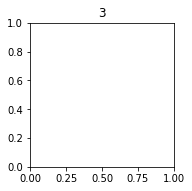

In [4]:
def display_samples(columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = train_image_names[i]
        image_id = name_target_dict[image_path.split('-')[0]]
        img = cv2.imread(r'./input/petfinder-adoption-prediction/train_images/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples()

> 0 - Pet was adopted on the same day as it was listed. 
> 
> 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
> 
> 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
> 
> 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
> 
> 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

## 2. Dataframe and Data Generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


We first create a dataframe to be used by the generator.

In [6]:
generator_dict = {'filename': [], 'class': []}

for name in train_image_names:
    short_name = name.split('-')[0]
    label = name_target_dict[short_name]
    
    generator_dict['filename'].append(name)
    generator_dict['class'].append(label)

generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

,filename,class
0,0008c5398-1.jpg,3
1,0008c5398-2.jpg,3
2,0008c5398-3.jpg,3
3,0008c5398-4.jpg,3
4,0008c5398-5.jpg,3
5,0008c5398-6.jpg,3
6,000a290e4-1.jpg,2
7,000a290e4-2.jpg,2


Now we define a data generator object, with data augmentation

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.1,  # set range for random shear
    zoom_range=0.1,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1/255.,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.1
)

def create_generator(subset):
    return datagen.flow_from_dataframe(
        generator_df, 
        r'./input/petfinder-adoption-prediction/train/train_images', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(100, 100), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=128, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
val_generator = create_generator('validation')

Found 52480 images belonging to 5 classes.
Found 5831 images belonging to 5 classes.


## 3. Model Training

In [8]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.applications import DenseNet121

We first create a simple model taken from the keras examples. To see the model summary, click on "Output".

In [9]:
model = DenseNet121(
    weights=None, 
    include_top=True, 
    classes=5,
    input_shape=(100, 100, 3)
)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#model.summary()

We create a checkpoint callback to keep track of the best model.

In [10]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

Train and evaluate the model

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=75000 / 128, 
    epochs=2,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=2, 
    verbose=1
)

Epoch 1/2


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\site-packages\keras\utils\data_utils.py", line 565, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\site-packages\keras\utils\data_utils.py", line 548, in <lambda>
    initargs=(seqs,))
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\multiprocessing\pool.py", line 175, in __init__
    self._repopulate_pool()
  File "C:\Users\vinograd\Anaconda5.3\e

## 4. Evaluation

In [ ]:
model.load_weights('model.h5')

val_scores = model.evaluate_generator(
    generator=val_generator,
    steps=len(val_generator),
    use_multiprocessing=True,
    verbose=1,
    workers=2
)

print('\nValidation loss:', val_scores[0])
print('Validation accuracy:', val_scores[1])

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## 5. Submission

In [ ]:
sample_submission_df = pd.read_csv(r'./input/petfinder-adoption-prediction/test/sample_submission.csv')
print(sample_submission_df.shape)
sample_submission_df.head()

Create submission dictionary similar to above.

In [ ]:
submission_dict = {'PetID': [], 'filename': []}

for name in test_image_names:
    pet_id = name.split('-')[0]
    submission_dict['PetID'].append(pet_id)
    submission_dict['filename'].append(name)
    
submission_df = pd.DataFrame(submission_dict)
submission_df.head()

`class_mode` arguments:
>  - None, no labels are returned (the generator will only yield batches of image data, which is useful to use `model.predict_generator()`, `model.evaluate_generator()`, etc.).

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
    submission_df,
    r'./input/petfinder-adoption-prediction/test_images',
    has_ext=True,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=256,
    shuffle=False,
    class_mode=None
)

In [ ]:
test_predictions = model.predict_generator(
    test_generator,
    workers=2, 
    use_multiprocessing=True, 
    verbose=1
)

Remove the filename from the dataframe, add the probabilities of each class.

In [ ]:
submission_df = submission_df.join(pd.DataFrame(test_predictions))
submission_df.drop(columns=['filename'], inplace=True)
print(submission_df.shape)
submission_df.head()

Take the average of the classes probabilities for each pet (since we have multiple pictures of each pet).

In [ ]:
submission_df = submission_df.groupby('PetID', as_index=False).mean()
print(submission_df.shape)
submission_df.head()

Select the class with highest probability to be added to the dataframe, drop the class probabilities.

In [ ]:
submission_df['AdoptionSpeed'] = submission_df.iloc[:,1:6].values.argmax(axis=1)
submission_df.drop(columns=[0,1,2,3,4], inplace=True)
print(submission_df.shape)
submission_df.head()

Save the dataframe as a CSV file.

In [ ]:
submission_df.to_csv('submission.csv',index=False)